In [86]:
%matplotlib inline
import os
import sys
import string
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from qm import*
from math import*
from random import shuffle

plt.rcParams['figure.figsize'] = (15,5)

qm = QuineMcCluskey()

In [93]:
#Lê o arquivo de extensao .kiss e separa as listas com as informações sobre a msf

temp = open('bbsse.kiss2')
line_char = temp.readlines()
l = []
entrada = []
lista_entradas = []
saida = []
lista_saidas = []

estados = []
estados = line_char[4:5]

atual = []
atual_inteiro = []
atual_convertido = []

proximo = []
proximo_inteiro = []
proximo_convertido = []

espaco_busca = []
espaco_aleatorio = []
estados_convertido = int(estados[0].split()[1])

#define o tamanho do espaço de busca basedado no valor entregue pelo arquivo

tamanho_espaco_busca = math.ceil(np.log2(estados_convertido))


msf_pronta = []

l = line_char[5:]

# nesse trecho os dados são separados, tratados e é criada a lista no formato que o Quine_Mccluskey pode simplificar

for i in range(len(l)):
    entrada = l[i].split()[0]
    lista_entradas.append(entrada)
    
    atual = l[i].split()[1]
    proximo = l[i].split()[2]
    saida = l[i].split()[3]
    lista_saidas.append(saida)
    
    atual_inteiro = int(atual[2:])
    proximo_inteiro = int(proximo[2:])
    atual_convertido.append(bin(atual_inteiro)[2:].zfill(tamanho_espaco_busca))
    #atual_binario = atual_convertido[i]
    proximo_convertido.append(bin(proximo_inteiro)[2:].zfill(tamanho_espaco_busca))
    #proximo_binario = proximo_convertido[i]
    linha = str(lista_entradas[i])+str(atual_convertido[i])+str(proximo_convertido[i])+str(lista_saidas[i])
    msf_pronta.append(linha)
    #print(msf_pronta[i])


#essa função calcula a quantidade de implicantes e variáveis de uma lista
    
def calculo_peso(lista_1):
    contador_dc = 0
    contador_termo = 0
    contador_literal = 0
    #tamanho_calculo = len(tamanho_espaco_busca)+len(saida)
    #para_calculo = lista_l[:tamanho_calculo]
    for i in range(len(lista_1)):
        contador_termo += 1
        for j in range(len(lista_1[i])):
            contador_literal +=1
            if (lista_1[i][j] == '-'):
                contador_dc += 1
    return (contador_termo+contador_literal)-contador_dc

# essa função separa da MSF as linhas relativas ao proximo estado e sáida para a contagem do peso

def prepara_lista(lista):
    para_calculo = []
    #print(len(entrada),len(atual_convertido[1]),len(proximo_convertido[1]),len(saida), len(lista[1]))
    for i in range(len(lista)):
        para_calculo.append(lista[i][len(entrada):-(len(saida))])
    return calculo_peso(para_calculo)
    

# neste ponto é criado o espaco de busca com todos as atribuicoes possíveis para representar a msf

for i in range (2**tamanho_espaco_busca):
        espaco_busca.append(bin(i)[2:].zfill(tamanho_espaco_busca))
        #espaco_aleatorio.append(bin(i)[2:].zfill(tamanho_espaco_busca))

# cria uma lista aleatória com os valores do espaço de busca

def cria_nova_msf():
    #print(tamanho_espaco_busca)
    espaco_aleatorio = espaco_busca.copy()
    shuffle(espaco_aleatorio)
    return set(espaco_aleatorio)

#nova_msf = []

# faz a comparação entre a lista entregue e o valor correspondente a ela na lista de valores aleatórios

def correspondente(palavra):
    espaco_aleatorio = list(cria_nova_msf())
    for i in range(len(espaco_busca)):
        if palavra == espaco_busca[i]:
            return str(espaco_aleatorio[i])

# recebe uma tabela, e a partir de comarações cria outra com os valores trocados pela atribuição aleatória

def nova_maquina():
    novo_atual = []
    novo_proximo = []
    nova_msf = []
    for i in range(len(l)):
        #print(atual_convertido[i],proximo_convertido[i])
        novo_atual.append(correspondente(atual_convertido[i]))
        #print("novo atual:",novo_atual[i])
        novo_proximo.append(correspondente(proximo_convertido[i]))
        #print("novo proximo:",novo_proximo[i])
        nova_atrib = str(lista_entradas[i])+str(novo_atual[i])+str(novo_proximo[i])+str(lista_saidas[i])
        nova_msf.append(nova_atrib)
        
    return nova_msf

def simplifica(lista):
    lista_simplificada = []
    lista_simplificada = qm.simplify_los(lista)
    return lista_simplificada

def calcula_custo(lista):
    nova_lista = []
    nova_lista_saidas = []
    nova_lista_transicoes = []
    lista_para_calculo = []
    comp_transit = len(entrada)+len(atual_convertido[0])
    comp_seg_lista = len(saida)+tamanho_espaco_busca
    for i in range(len(lista)):
        nova_lista.append(lista[i][:-len(saida)])
        nova_lista_saidas.append(lista[i][comp_transit:-len(saida)])
        nova_lista_transicoes.append(lista[i][:-comp_seg_lista])
        
    for i in range(len(nova_lista_saidas)):
        for j in range(len(nova_lista_saidas[i])):
            if nova_lista_saidas[i][j] == '1':
                #print(nova_lista_saidas[i])
                lista_para_calculo.append(nova_lista_transicoes[i])
    
    quantidade_dc = 0
    for i in range(len(lista_para_calculo)):
        for j in range(len(lista_para_calculo[i])):
            if lista_para_calculo[i][j] == '-':
                quantidade_dc += 1
                
    custo = (len(lista_para_calculo)*len(lista_para_calculo[0]))-quantidade_dc
    return custo
    #return nova_lista, nova_lista_transicoes, nova_lista_saidas,lista_para_calculo, custo
    
    
teste_nova_lista = nova_maquina()
teste = cria_nova_msf()
print(teste)
print(espaco_busca)    
#teste = list(qm.simplify_los(msf_pronta))
#teste1 = list(qm.simplify_los(teste_nova_lista))
for i in range(len(msf_pronta)):
    print(msf_pronta[i],len(msf_pronta[i]),"-->",teste_nova_lista[i],len(teste_nova_lista[i]))
#print(teste)
#print(calcula_custo(teste))
#print(teste1)
#print(calcula_custo(teste1))

    
# algoritmo do SA, que realiza as comparaçoes e entrega a atribuição com o menor peso após a simplificação
# a primeira iteração do SA, utiliza o valor da msf entregue pelo arquivo.kiss


{'1111', '0001', '1011', '1000', '0111', '1001', '0010', '1100', '0110', '0101', '0000', '1010', '1101', '0011', '0100', '1110'}
['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
0------000000000000000 22 --> 0------111101000000000 22
10----00000000100110-0 22 --> 10----01111111100110-0 22
10----10000000100010-0 22 --> 10----11111111000010-0 22
11----0000010110011010 22 --> 11----0111110100011010 22
11----1000010110001010 22 --> 11----1111110100001010 22
100----0001000100000-0 22 --> 100----1110010000000-0 22
101-1--0001010010000-0 22 --> 101-1--1110100010000-0 22
101-0--0001001010000-0 22 --> 101-0--0100010110000-0 22
0------00011011000--10 22 --> 0------11111010000--10 22
11-----000110110000010 22 --> 11-----010010100000010 22
10-----0010001100000-0 22 --> 10-----0001101100000-0 22
0------00101011000--10 22 --> 0------00011010000--10 22
11-----001010110000010 22 --> 11-----000110100000010 22
10--0--0011001

In [42]:
def simulated_annealing(temperatura):
    temperatura_inicial = temperatura
    temperatura_final = 10
    melhor = list(simplifica(msf_pronta))
    custo_inicial = calcula_custo(melhor)
    print(custo_inicial)
    historico = [calcula_custo(melhor)]
    while temperatura > temperatura_final:
        for i in range(5):
            nova_solucao = nova_maquina()
            np.warnings.filterwarnings('ignore')
            nova_solucao_simplificada = list(simplifica(nova_solucao))
            custo_local = calcula_custo(nova_solucao_simplificada)
            melhor_custo = calcula_custo(melhor)
            probabilidade = np.random.uniform(0, 3)
            if custo_local - melhor_custo < 0  or probabilidade < np.log((melhor_custo-custo_local)/temperatura):
            	melhor = nova_solucao_simplificada
            	historico.append(melhor_custo)
            	print(temperatura,"trocou!!")
        
        if temperatura > temperatura/2:
        	temperatura = temperatura-10
        else:
        	temperatura = temperatura-5
        #print(temperatura)
    
    custo_final = calcula_custo(melhor)
    melhora = 100-((custo_final *100)/custo_inicial)
    
    return melhor, historico, melhora


176
01010101101
11100110011
01011001101
1000000001-
10100110101
10011110001
01001000101
0010-00000-
0000-100111
11001010011
10100010001
10101010101
01001101001
00011101111
00000000000
110-0101011
00001001111
10000100011
01010001001
0001-00000-
0100000010-
[176]
melhorou: 0.0 %


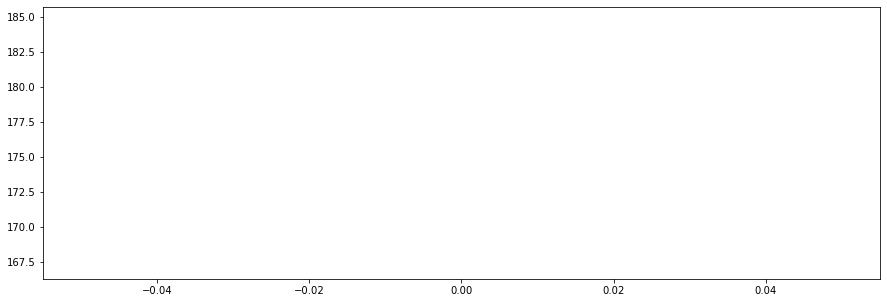

In [43]:
temperatura = 1000
resultado, historico, melhora_da_solucao = simulated_annealing(temperatura)
for i in range(len(resultado)):
	print(resultado[i])
print(historico)
print("melhorou:",melhora_da_solucao,"%")
plt.plot(historico)
#plt.plot(historico, hv(historico))
